# Movie recommender system


1. Rank based recommendation
2. Content based recommendation
3. Collaborative based recommendation

In [9]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [345]:
# Load in datasets
movie_df = pd.read_csv('TMDB5000/tmdb_5000_movies.csv')
credit_df = pd.read_csv('TMDB5000/tmdb_5000_credits.csv')

## 1. Rank based recommendation
This kind of recommendation provides a general recommendation to every users, similar to the 'Trending Now' section in some websites. This is useful for when we have no prior knowledge about the user, i.e. his view history.

For this general recommender, the algorithm will take into account the following factors:
1. Rating - instead of taking the avg. rating at is face value, we should only consider movies with vote # above a certain threshold
2. Revenue - 
3. Release Date - we don't want our trending now to be filled with movies released decades years ago

### EDA

In [25]:
# Convert to datetime object
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])

# Days since release
from datetime import timedelta
ref_date = movie_df['release_date'].max()
movie_df['release_days'] = movie_df['release_date'].apply(lambda x: (ref_date-x).days)

In [51]:
columns = ['revenue','release_days','vote_average','vote_count']
movie_df[columns].describe()

,revenue,release_days,vote_average,vote_count
count,4.803000e+03,4802.000000,4803.000000,4803.000000
mean,8.226064e+07,5151.009788,6.092172,690.217989
std,1.628571e+08,4529.084250,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,2179.000000,5.600000,54.000000
50%,1.917000e+07,4141.000000,6.200000,235.000000
75%,9.291719e+07,6414.000000,6.800000,737.000000
max,2.787965e+09,36677.000000,10.000000,13752.000000


In [67]:
# Set the vote # threshold, and filter out movies below it
threshold = movie_df['vote_count'].quantile(0.8)
movie_df = movie_df[movie_df['vote_count'] >= threshold]

#### IMDB weighted average rating
The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:

R = average for the movie (mean) = (Rating)\
v = number of votes for the movie = (votes)\
m = minimum votes required to be listed in the Top 250 (currently 25000)\
C = the mean vote across the whole report (currently 7.0)

In [72]:
# Calculate weighted average rating using IMDB's formula
m = movie_df['vote_count'].min()
C = movie_df['vote_average'].mean()

def weighted_rating(row, m=m, C=C):
    v = row['vote_count']
    R = row['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movie_df['weighted_rating'] = movie_df.apply(weighted_rating, axis=1)

If we only use the weighted rating as the metric, we will have the following top 10 movies. 

In [153]:
# Top 10 'trending now' movies
movie_df[['original_title','weighted_rating']].sort_values('weighted_rating', ascending=False).head(10).reset_index(drop=True)

,original_title,weighted_rating
0,The Shawshank Redemption,8.317292
1,The Godfather,8.169617
2,Fight Club,8.157048
3,Pulp Fiction,8.142046
4,The Dark Knight,8.092997
5,Forrest Gump,8.043922
6,Schindler's List,8.019584
7,Whiplash,8.015549
8,Inception,8.012239
9,The Empire Strikes Back,7.997169


The above list makes a great 'All Time Great Movies' section, however, since we are looking at 'Trending Now', we must account for the time factor in the metric.

In [77]:
# Calculate the inverse of log(days) to give preference to recent movies over old ones
epsilon = 0.0001
movie_df['release_days_inv'] = movie_df['release_days'].apply(lambda x: 1/np.log(x))

In [136]:
# For missing revenue, impute the medium
movie_df['revenue'] = movie_df['revenue'].replace(0, np.nan)
movie_df['revenue'] = movie_df['revenue'].fillna(movie_df['revenue'].median())

# Calculate the log of revenue
movie_df['revenue_log'] = np.log(movie_df['revenue'])

In [137]:
# Calculate the score: weighted_rating * release_days_inv * revenue_log
movie_df['score'] = movie_df['weighted_rating']*movie_df['release_days_inv']*movie_df['revenue_log']

Combining the weighted rating, revenue and time factor, we get the following top 10 movies:

In [152]:
# Top 10 'trending now' movies
movie_df[['original_title','score']].sort_values('score', ascending=False).head(10).reset_index(drop=True)

,original_title,score
0,Captain America: Civil War,26.108285
1,Me Before You,25.637547
2,Deadpool,25.565329
3,Inside Out,25.180566
4,The Martian,24.520108
5,Star Trek Beyond,24.390507
6,The Jungle Book,24.321812
7,Nerve,24.292167
8,The Conjuring 2,24.266662
9,Interstellar,24.209251


## 2. Content based recommendation
Content based recommender system suggests similar movies to the current movie based on the content, in terms of the genre, director, keywords, description, etc. 

In [249]:
# Reset datasets
movie_df = pd.read_csv('TMDB5000/tmdb_5000_movies.csv')
credit_df = pd.read_csv('TMDB5000/tmdb_5000_credits.csv')

### 2.1 Description based recommendation

In [202]:
import nltk
from nltk.stem.porter import * 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

In [250]:
# Lowercase, remove numerical characters, punctuations, double-space, lemmatize, stemming
lemma = nltk.wordnet.WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    text = str(text).lower()
    text = ' '.join([lemma.lemmatize(word) for word in text.split()])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^\w\s]','',text)
    text = text.replace('  ',' ')
    return text

movie_df['overview_cleaned'] = movie_df['overview'].astype(str).apply(preprocess)

In [251]:
# Define the max_features, max_df, min_df
max_features = None # the top n vocabularies
max_df = 0.9 # ignore words that appear in 90% of the documents

# Create an n_sample*max_features matrix
vectorizer = TfidfVectorizer(analyzer='word', 
                             stop_words='english', 
                             max_features=max_features,
                             max_df=max_df) 

X = vectorizer.fit_transform(movie_df.overview_cleaned)

In [252]:
def cal_similarity(X, query, vectorizer, top=5):
    query = [preprocess(query)]
    vector = vectorizer.transform(query)
    similarity = cosine_similarity(X, vector).flatten() 
    top_sim_scores = np.sort(similarity)[-top-1:-1][::-1]
    indices = np.argsort(similarity, axis=0)[-top-1:-1][::-1]
    for movie, score in zip(movie_df.original_title[indices].to_list(), top_sim_scores):
        print(movie)

In [255]:
# Randomly select a movie from the dataset
query = movie_df.overview.sample()
print(f'Movie: {movie_df.original_title[query.index[0]]}')
print(f'Description: {movie_df.overview[query.index[0]]}')

Movie: Batman v Superman: Dawn of Justice
Description: Fearing the actions of a god-like Super Hero left unchecked, Gotham City’s own formidable, forceful vigilante takes on Metropolis’s most revered, modern-day savior, while the world wrestles with what sort of hero it really needs. And with Batman and Superman at war with one another, a new threat quickly arises, putting mankind in greater danger than it’s ever known before.


In [256]:
# Show the top n similar movies
cal_similarity(X, query,vectorizer,top=5)

2001: A Space Odyssey
Despicable Me 2
Last Action Hero
American Hero
Zoom


### 2.2 Metadata based recommendation

In [346]:
# Convert dataframe string objects into list/dictionary objects
import ast
movie_df['genres'] = movie_df['genres'].apply(ast.literal_eval)
movie_df['keywords'] = movie_df['keywords'].apply(ast.literal_eval)
movie_df['production_companies'] = movie_df['production_companies'].apply(ast.literal_eval)
movie_df['production_countries'] = movie_df['production_countries'].apply(ast.literal_eval)
movie_df['spoken_languages'] = movie_df['spoken_languages'].apply(ast.literal_eval)

credit_df['cast'] = credit_df['cast'].apply(ast.literal_eval)
credit_df['crew'] = credit_df['crew'].apply(ast.literal_eval)

In [347]:
# Merge movie cast into movie_df
movie_df = movie_df.merge(credit_df[['movie_id','cast','crew']], how='left', left_on='id', right_on='movie_id')

Metadata attributes for recommendation:
1. Genres
2. Cast
3. Keywords
4. Language
5. Director

We will use a technique similar to that of description based content filtering by combining all metadata attributes into text strings and then vectorize the strings.

In [373]:
# A function that joins all relevant attributes into a sentence
def metadata_to_string(row):
    genres = ['_'.join(i['name'].lower().split()) for i in row['genres']]
    cast = ['_'.join(i['name'].lower().split()) for i in row['cast'][:5]]
    keywords = [i['name'].lower() for i in row['keywords']]
    language = ['language_'+i['name'].lower() for i in row['spoken_languages']]
    director = ['_'.join(i['name'].lower().split()) for i in row.crew if i['job'] == 'Director']
    joined = [*genres, *cast, *keywords, *language, *director]
    return ' '.join(joined)

movie_df['metadata_combined'] = movie_df.apply(metadata_to_string, axis=1)

In [469]:
# A sample of the combined string of metadata
movie_df['metadata_combined'].sample().values[0]

'action drama thriller war mark_wahlberg taylor_kitsch emile_hirsch ben_foster yousuf_azami war survival navy seal military dangerous mission language_english peter_berg'

In [376]:
# Create an n_sample*max_features matrix
vectorizer = TfidfVectorizer(analyzer='word', 
                             stop_words='english')

X = vectorizer.fit_transform(movie_df.metadata_combined)

In [465]:
def cal_similarity(X, query, vectorizer, top=5):
    vector = vectorizer.transform([query])
    similarity = cosine_similarity(X, vector).flatten() 
    top_sim_scores = np.sort(similarity)[-top-1:-1][::-1]
    indices = np.argsort(similarity, axis=0)[-top-1:-1][::-1]
    for movie, score in zip(movie_df.original_title[indices].to_list(), top_sim_scores):
        print(movie)

In [473]:
query = movie_df['metadata_combined'][9]
print(f'Movie: {movie_df.original_title[9]}')
print(f'Description: {movie_df.metadata_combined[9]}')

Movie: Batman v Superman: Dawn of Justice
Description: action adventure fantasy ben_affleck henry_cavill gal_gadot amy_adams jesse_eisenberg dc comics vigilante superhero based on comic book revenge super powers clark kent bruce wayne dc extended universe language_english zack_snyder


In [474]:
cal_similarity(X, query, vectorizer, top=5)

Man of Steel
Suicide Squad
Superman III
Superman Returns
The Dark Knight


## 3. Collaborative recommendation
The idea of collaborative filtering is to identify similar users based based on their past user-movie interactions (e.g. view & rating history).

SVD is a widely used algorithm in building recommendation engines. The Surprise library is designed for recommendation algorithms and offers quick and easy implementation of SVD.

In [216]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

ratings = pd.read_csv('Movie_dataset/ratings_small.csv')
ratings['movieId'] = ratings['movieId'].astype(str)

movies = pd.read_csv('Movie_dataset/movies_metadata.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [217]:
# Convert pandas dataframe to Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Cross validate
cross_validate(svd, data, measures=['RMSE'])

{'test_rmse': array([0.89744025, 0.89941525, 0.88694631, 0.90110415, 0.90215658]),
 'fit_time': (3.5988101959228516,
  3.567330837249756,
  3.578468084335327,
  3.6153180599212646,
  3.592587947845459),
 'test_time': (0.18824982643127441,
  0.09254217147827148,
  0.14005470275878906,
  0.09510183334350586,
  0.14249014854431152)}

In [270]:
# Fit and predict
trainset = data.build_full_trainset()
svd.fit(trainset)

movie_id = 862
user_id = 212
svd.predict(uid=str(user_id), iid=str(movie_id))

Prediction(uid='212', iid='862', r_ui=None, est=3.543608255669773, details={'was_impossible': False})

In [271]:
# Merge ratings and movies dataframes
ratings_ = ratings[ratings.userId==user_id][['movieId','rating']]
ratings_['movieId'] = ratings_['movieId'].astype(str)
movies_ = movies[['id','original_title','release_date']]
movies_ = movies_.merge(ratings_, how='left', left_on='id', right_on='movieId')

# The top 10 movies watched and rated by the user
movies_[movies_['id'].isin(ratings_['movieId'].values)].sort_values('rating', ascending=False).head(10)

,id,original_title,release_date,movieId,rating
25980,4226,Shriek If You Know What I Did Last Friday the ...,2000-10-17,4226,5.0
302,110,Trois couleurs : Rouge,1994-05-27,110,5.0
11922,2959,License to Wed,2007-07-04,2959,5.0
7056,778,Les Vacances de Monsieur Hulot,1953-02-26,778,5.0
33913,3578,Der Tunnel,1933-10-26,3578,5.0
534,858,Sleepless in Seattle,1993-06-24,858,5.0
2065,4011,Beetlejuice,1988-02-29,4011,5.0
286,527,Once Were Warriors,1994-09-02,527,5.0
5295,4993,5 Card Stud,1968-07-28,4993,5.0
4020,318,The Million Dollar Hotel,2000-02-09,318,4.5


In [272]:
# Recommend the Top 10 movies to the user
movies_['pred_rating'] = movies_.id.apply(lambda x: svd.predict(user_id, x).est)
movies_[movies_.rating.isna()].sort_values('pred_rating', ascending=False).head(10)

,id,original_title,release_date,movieId,rating,pred_rating
459,2019,Hard Target,1993-08-20,NaN,NaN,4.097386
278,1945,Nell,1994-12-23,NaN,NaN,4.078063
8737,5618,"Cousin, Cousine",1975-11-19,NaN,NaN,4.044852
5325,608,Men in Black II,2002-07-03,NaN,NaN,4.042002
8316,905,Die Büchse der Pandora,1929-01-30,NaN,NaN,4.030097
2647,745,The Sixth Sense,1999-08-06,NaN,NaN,3.996880
11732,1272,Sunshine,2007-04-05,NaN,NaN,3.985806
2533,3035,Frankenstein,1931-11-21,NaN,NaN,3.984759
12751,31658,Hour of the Gun,1967-11-01,NaN,NaN,3.976372
16080,3007,Frau im Mond,1929-10-14,NaN,NaN,3.959116


## Understanding the SVD algorithm

Singular Vector Decomposition (SVD) makes use of the concept of matrix factorization where a given matrix is factorized (decomposed) into 2 or more matrices so that when the matrices are multiplied together, we'll get back the original, or a similar, matrix. 

Under a user rating matrix context, it suggests that a user's rating of a movie can be decomposied into two parts or matrices: his preference about different aspects and attributes of a movie (e.g. 1 action, 1 romance, 4 thriller); and the attributes of a given movie (10% actino, 30% romance, 60% thriller). Computing the dot product of the two vectors should give the user's rating of such movie i.e. *1x0.1 + 1x0.3 + 4x0.6 = 2.8.*

An advantage of matrix factorization is memory efficiency. Imagine a 100x100 matrix with 10,000 data points is decomposed into 2 matrices with the shape of 100x2 and 2x100, we'll have only 200+200=400 data points, that's 96% less memory usage!

Singular Value Decomposition (SVD) states that every (m × n)‑matrix A can be written as a product

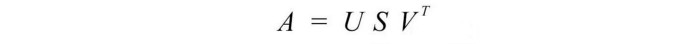

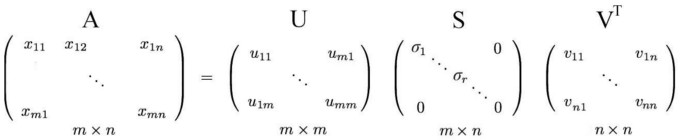

However, SVD only works with complete full matrices and works poorly with sparse data, which unforetunately is often the case with real life datasets. When was the last time you actually left a rating?

We need to impute missing values for SVD to work. SVD is not a computing algorithm, we need to figure out a way to impute the missing values, such as zeros, mean, etc. In Simon Funk's approach, null values are ignored and stochastic gradient descent is used to minimize the errors between the full matrix and the approximate matrix, for non-null values.



#### Create a user-movie rating matrix
The matrix will be a m by n matrix, where m = number of users and n = number of movies, and the value at (i,j) will be the rating given by user i to movie j.

Panda's pivot() method does exactly that in a one-liner, we'll just have to convert that to a numpy array.

In [152]:
# Ratings utility matrix and impute null values with 0
ratings_pivot = ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
rating_matrix = np.array(ratings_pivot)

# Shape of the user-movie matrix
rating_matrix.shape

(9066, 671)

In [153]:
# Take the mean per-movie rating along the row, i.e. axis=1
user_ratings_mean = np.mean(rating_matrix, axis = 1)

# De-mean the data, i.e. subtract the mean from each rating
rating_matrix_demeaned = rating_matrix - user_ratings_mean.reshape(-1,1)

In [155]:
from numpy.linalg import svd
U, sigma, Vt = svd(rating_matrix_demeaned, full_matrices=True)

# Shape of the factorized matrix
print(f'U: {U.shape}\nsigma: {sigma.shape}\nVt: {Vt.shape}')

U: (9066, 9066)
sigma: (671,)
Vt: (671, 671)


In [156]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(rating_matrix_demeaned, k=200)

# Shape of the factorized matrices
print(f'U: {U.shape}\nsigma: {sigma.shape}\nVt: {Vt.shape}')

U: (9066, 200)
sigma: (200,)
Vt: (200, 671)


As opposed to Numpy's full_matrices implementation, Scipy's SVD takes in the *k* argument, which is the number of singular values/vectors, or the rank. An advantage of specifying the *k* is faster computing since we have smaller matrices to deal with. The difference between the 2 is aptly illustrated below:

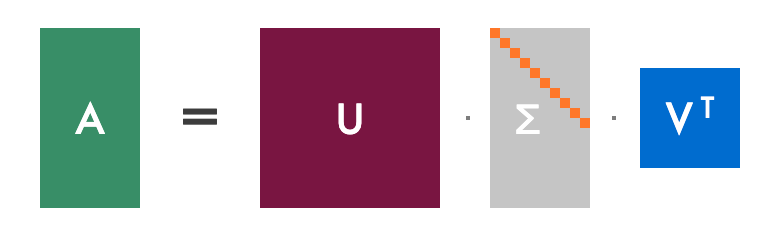 (Numpy)

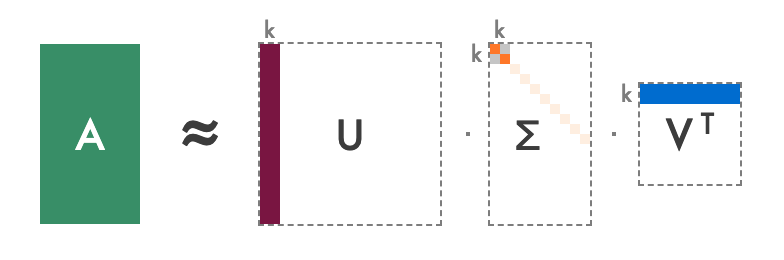 (Scipy)

By specifying *k* number of singular values, we can compute an approximation to the original matrix that takes only a fraction of the space to store. The higher this number, the better the quality of the approximation but also the more memory it consumes. 

Note that in both Numpy and Scipy's SVD, the *sigma* is a 1D vector. Hence, in order to perform matrix multiplication of *U, sigma, Vt*, we need to convert it to diagonal matrix form as it is supposed to be.

In [157]:
print(f'Orginal sigma shape: {sigma.shape}')

sigma = np.diag(sigma)
print(f'New sigma shape: {sigma.shape}')

Orginal sigma shape: (200,)
New sigma shape: (200, 200)


In [274]:
# Matrix multiplication of U, sigma, Vt to return an approximation of the original matrix
pred_ratings_matrix = U @ sigma @ Vt + user_ratings_mean.reshape(-1,1)
pred_ratings = pd.DataFrame(pred_ratings_matrix, index = ratings_pivot.index, columns = ratings_pivot.columns)

# Predict a user's rating
pred = pred_ratings.loc[movie_id][user_id]
print(f"User {user_id}'s rating for movie {movie_id}: {pred:.3f}")


User 212's rating for movie 862: 2.655


In [160]:
ratings_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,3.0,3.5,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,4.0,0.0,0.0,...,0.0,4.5,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,5.0,3.5,5.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
pred_ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.167206,-0.670638,0.278724,-0.041197,0.540210,-0.059233,3.529492,0.660611,2.300487,-0.551829,-0.043431,0.023034,3.950323,0.350567,1.921199,-0.128266,0.108575,1.172455,2.486163,4.617103,1.127159,-0.295976,3.120372,0.620154,1.326988,5.395415,-0.233300,0.020653,0.107505,3.968139,0.775297,0.266482,-0.693158,0.200017,0.083586,0.531305,2.571779,-0.284717,0.901889,-0.203530,-0.128927,0.551620,3.830079,2.972908,-0.175542,0.537857,2.980998,3.933234,-0.045873,-0.103553,...,0.080900,5.712810,5.024787,-0.519898,0.616064,-0.195547,-0.517455,-0.248217,2.434977,0.219046,0.960855,0.357216,0.289718,-0.099971,2.455320,0.759408,0.137971,0.704238,1.479178,3.296871,-0.153844,0.297444,0.073719,-0.282780,5.372148,4.225809,-0.396304,3.948728,0.367332,0.343263,0.001790,3.811718,4.928481,0.408942,-0.619357,0.623827,0.859787,-0.475267,3.103040,0.057047,-0.270026,2.537434,3.471763,-0.117601,-0.171401,0.226605,0.426546,0.247995,1.832339,3.725372
2,-0.095230,0.598414,0.394241,-0.077672,0.337873,0.210678,0.678755,-0.452101,-0.602999,0.262917,0.100011,0.388203,0.686310,-0.121702,1.892108,-0.197239,0.014493,0.024026,3.020449,0.582834,0.548290,-0.694081,0.045471,-0.468154,0.226303,0.349639,-0.370547,-0.037033,0.189931,1.962506,0.138036,2.294806,-0.056388,1.142646,0.087199,-0.216322,-0.284923,0.153327,0.172552,0.135560,3.999100,-0.254477,0.117422,0.009196,0.082198,0.941207,1.654494,3.611472,2.240610,0.829700,...,-0.071269,1.152856,3.036273,0.200959,-0.549252,0.563761,-0.061807,0.423887,0.077518,0.307560,0.381667,0.677992,0.041721,0.111002,0.110392,0.488884,-0.246908,0.839096,0.015489,4.061118,0.307070,0.050585,0.137408,0.120978,0.326014,-0.927568,0.479941,1.393092,0.583104,0.157224,-0.059066,0.322192,3.139931,2.604745,0.201157,-0.102127,0.022453,0.396599,0.689647,0.100841,2.998870,-0.237391,-0.195651,2.852349,0.484755,0.662245,-0.067073,0.016153,-0.170989,-0.262639
3,0.144217,-0.356787,-0.512780,0.187683,1.732300,0.207933,0.321992,0.500032,-0.128760,-0.222786,-0.149418,0.351862,0.017275,0.113521,0.080291,-0.126323,-0.034832,2.471867,2.999181,0.175877,-0.229409,0.472194,0.109643,0.263679,1.356781,-0.471609,-0.251224,-0.169719,-0.144243,0.051352,-0.210671,0.188474,0.210267,0.060199,-0.073693,0.249580,-0.015052,-0.405867,0.152499,-0.582445,-0.457450,-0.311788,-0.077602,2.007546,0.082839,0.086974,-0.003461,0.059583,-0.055818,0.254671,...,0.169067,0.504404,3.007857,-0.129781,0.057756,-0.715246,-0.134429,0.188447,0.273709,-0.167602,0.135372,0.018565,0.284248,-0.088967,0.823098,0.051309,-0.001106,-0.063718,2.762316,2.864916,-0.114546,0.071688,0.180143,0.123399,4.555892,0.068737,-0.324803,-0.024775,1.359529,0.102259,0.124359,-0.231191,-0.063738,0.005125,-0.104806,0.060396,-0.408650,0.363634,-0.161062,-0.004278,0.027998,0.077072,0.003983,2.563603,-0.159017,0.325156,0.129728,0.236206,-0.110774,-0.078155
4,0.026736,0.075546,0.001497,-0.112607,-0.165688,0.041646,0.241110,-0.043075,-0.013611,-0.013658,-0.069381,-0.028216,0.121983,0.023660,0.030629,-0.117907,0.052870,0.030285,2.510333,0.190575,0.286123,-0.123081,0.046684,-0.085102,0.029113,0.023159,-0.074605,-0.042208,-0.013547,0.088053,-0.029498,0.108809,-0.262892,0.239991,0.059772,0.311678,-0.028680,-0.275053,0.066962,0.014779,-0.145085,0.027196,0.146228,0.026527,-0.017339,0.035922,-0.034453,0.049328,0.264557,0.106609,...,-0.046072,0.218795,0.010322,-0.039614,0.110278,-0.162496,0.147034,0.075763,0.115356,-0.093940,-0.074978,0.003579,0.017147,-0.031148,-0.074306,0.056088,0.028775,0.118181,0.122796,0.453920,0.145409,-0.085458,0.015590,0.012986,-0.095794,-0.094011,-0.05

Simply looking at these matrices does not tell much about how well the matrix factorization did. Let's compute the error between the original matrix and the approximated one where (i,j) is not null. We'll use RMSE as the error metric.

In [132]:
import numpy.ma as ma

# First we need to create a mask from the original matrix, and overlay it on pred_ratings_matrix
mask = np.where(rating_matrix==0., 1, 0)
pred_ratings_masked = ma.masked_array(pred_ratings_matrix, mask=mask)

# Calculate RMSE between the original matrix and the approximated matrix (for non-null ratings only)
rmse = np.sqrt(np.mean((pred_ratings_masked-rating_matrix)**2))
print(f'RMSE: {rmse:.3f}')

RMSE: 0.842


The greater the number of singular values K, the better the approximation the resultant matrix is to the original matrix, and the more information the matrix should preserve, and the smaller the error. If we plot a graph of the number of K against the loss (RMSE), we should observe a decreasing curve, let's plot this out!

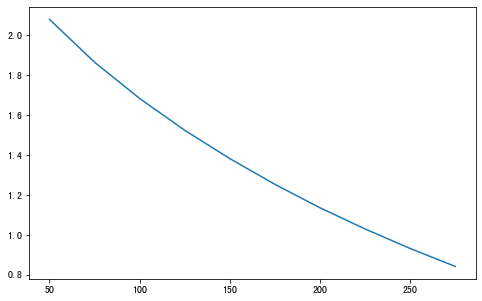

In [125]:
import matplotlib.pyplot as plt

rmse = []
for k in range(50,300,25):
    U, sigma, Vt = svds(rating_matrix_demeaned, k=k)
    pred_ratings_matrix = U @ np.diag(sigma) @ Vt + user_ratings_mean.reshape(-1,1)
    pred_ratings_masked = ma.masked_array(pred_ratings_matrix, mask=mask)
    rmse.append(np.sqrt(np.mean((pred_ratings_masked-rating_matrix)**2)))

# Plot how RMSE changes with K
plt.figure(figsize=(8,5))
plt.plot(list(range(50,300,25)), rmse)
plt.show()

# To be continued...
To get an even better movie recommender system, we could try using a hybrid model, i.e. one that combines ranked-based, content-based and collaborative-based recommendations.